# Recurrent Neural Networks (RNNs) for Natural Language Processing (NLP)

In the last notebook, we explored time series sequences, and in this notebook, we delve into a different type of sequence commonly encountered in natural language processing (NLP) applications. This notebook showcases Recurrent Neural Network (RNN) models in tasks such as:

* Sentiment analysis using the IMDB reviews dataset.
* Generating fake text character-by-character.

As we do so, we will learn important NLP techniques for text manipulation. Let's get started.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import lightning as L
import torchtext
import matplotlib.pyplot as plt

## Example 1: Sentiment Analysis

In this example, we leverage the IMDB movie reviews dataset to determine whether reviews convey negative (1) or positive(2) sentiments. We will use `torchtext.datasets.IMDB` to download this data. The dataset comprises two splits, each containing 25,000 movie reviews from IMDB. To speed up the training process, we will use only portions of these splits: 40% of the train split for training, 30% of the test split for testing, and 20% of the test split for validation.

In [2]:
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split

ds_train, _ = random_split(list(IMDB(root = './datasets', split='train')), [.40, .60])

ds_val, ds_test, _ = random_split(list(IMDB(root = './datasets', split='test')), [.20, .30, .50])

len(list(ds_train)), len(ds_val), len(ds_test)

(10000, 5000, 7500)

Let's print some of the training reviews.

In [3]:
for i, (labels, reviews) in enumerate(ds_train):
    print("REVIEW:", reviews, "...")
    print("LABEL:", labels, "\n")

    if i > 3: break

REVIEW: I honestly had no idea that the Notorious B.I.G. (Bert I. Gordon the director; not the murdered rapper) was still active in the 80's! I always presumed the deliciously inept "Empire of the Ants" stood as his last masterful accomplishment in the horror genre, but that was before my dirty little hands stumbled upon an ancient and dusty VHS copy of "The Coming", a totally obscure and unheard of witchery-movie that actually turned out a more or less pleasant surprise! What starts out as a seemingly atmospheric tale of late Dark Ages soon takes a silly turn when a villager of year 1692 inexplicably becomes transferred to present day Salum, Massachusetts and promptly attacks a girl in the history museum. For you see, this particular girl is the reincarnation of Ann Putman who was a bona fide evil girl in 1692 and falsely accused over twenty people of practicing witchcraft which led to their executions at the state. The man who attacked Loreen lost his wife and daughter this and wants

### Text Vectorization

To use these datasets, the reviews must undergo vectorization, converting them into numerical representations. This process involves several steps:

* **Tokenization**: This step involves splitting the raw text into individual tokens, such as words or characters. Simple tokenization methods include splitting text by whitespace.

* **Numerical Encoding**: Each token in the text needs to be mapped to a unique integer index, as RNNs require numerical inputs. This step typically involves creating a vocabulary that maps tokens to indices. Special tokens like `<unk>` (unknown) for out-of-vocabulary words and `<pad>` (padding) for sequences of varying lengths may also be included.

* **Sequence Padding**: Ensure that all sequences have the same length by padding or truncating them as needed. RNNs operate on fixed-length sequences, so sequences may need to be padded with special tokens (e.g., `<pad>`) to match the maximum sequence length. Padding ensures uniform length for efficient batch processing during training.

* **Embedding** (optional): This step involves converting the numerical indices into dense vector representations called embeddings. Instead of using one-hot encoding, which results in high-dimensional and sparse representations, embeddings capture semantic similarities between tokens in a lower-dimensional space. These embeddings can be learned from scratch during training or initialized with pre-trained word embeddings (e.g., Word2Vec, GloVe, or FastText) to leverage existing semantic knowledge.

Let's observe these steps in action using the above IMDB reviews.

**Tokenization**

In this step, we clean the data and then split it into token words. The cleaning steps involve:

* Removing all HTML tags from the reviews. We will use the Beautiful Soup package for this purpose, which can be installed as follows:

In [4]:
# ! pip install beautifulsoup4 -q

* Remove all URLs from the text.
* Remove all characters other than alphanumeric characters and spaces.

Here is a function that performs all these cleaning steps, using regular expression and the above beautiful soup package.

In [5]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub("http\S+", "", text)
    text = re.sub("[^A-Za-z0-9 ]+", "", text)
    
    return text

Next, we use the basic English tokenizer from `torchtext.data` to tokenize the reviews after they have been cleaned. As the reviews are being tokenized, we pass them to a Counter object from Python's `collections` module to count how many times each token (word) has been seen. This will be important to creating a vocabulary.

In [8]:
from collections import Counter#, OrderedDict
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")
token_counts = Counter()
for label, review in ds_train:
    tokens = tokenizer(clean_text(review))
    token_counts.update(tokens)

print('Vocab-size:', len(token_counts)) 

/var/folders/sl/bgp1_cy52nq1s2vbr1xsgcw00000gn/T/ipykernel_16559/57302828.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Vocab-size: 81461


As you can see, we have over 82,000 unique tokens in the training dataset. To build a vocabulary object for these tokens, we need to create a mapping from each token to its index in the list of all tokens. However, it's essential that the most frequent tokens appear first in the vocabulary. Therefore, we sort the tokens by their counts in decreasing order and add them to an ordered dictionary. This ordered dictionary can then be passed to `torchtext.vocab.vocab` to create a vocabulary object for these tokens based. 

Given that many tokens are infrequent, we don't need to include all 82,000 tokens in the vocabulary. Instead, we will only add the top 9,998 most frequent tokens. Additionally, we will include special tokens to make it a total of 10,000 tokens.

In [7]:
from collections import OrderedDict
from torchtext.vocab import vocab

sorted_token_counts = sorted(
    token_counts.items(), key=lambda x: x[1], reverse=True
)

vocab_size = 10_000 - 2
vocab = torchtext.vocab.vocab(OrderedDict(sorted_token_counts[:vocab_size]))
len(vocab)

9998

We will now add the aforementioned special tokens:

* `<pad>` (padding) with index 0, which ensures that sequences have the same lengths.
* `<unk>` (unknown) with index 1, representing out-of-vocabulary words. This token serves as the default index. For instance, if a review contains a word that is not present in the training dataset or among the top 9,998 most frequent words, it is represented by this token.

In [8]:
vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

len(vocab)

10000

Here is an example of how the vocabulary we just created can be used. Here is the first review along with its numerical representation.

In [9]:
for label, review in ds_train:
    print("REVIEW:\n", review)
    print("\nVECTORIZED:\n", [vocab[token] for token in tokenizer(clean_text(review))])
    break

REVIEW:
 This movie isn't terrible, really. Somebody commented that Mo is the type of American Europeans snicker at. But there are those, and not necessarily Anglo-Saxon yahoos, who do not care for Frenchmen; and the Xavier character isn't going to sway them.<br /><br />Let's consider his stereotypical Frenchman attributes:<br /><br />1). Cynical - very cynical. Check.<br /><br />2). Reedy, underfed appearance, check, despite:<br /><br />3). A great appreciation of cuisine. Check.<br /><br />4). Lukewarm work ethic. Check. (Forget the fact he is supposedly a rich stockbroker, from watching him in the film he seems to put in ten hour workweeks.) <br /><br />5). Beautiful wife, check. Despite that:<br /><br />6). Loose interpretation of the marriage vows. Check.<br /><br />7). Big sexual ego, which says an American girl owes you sex if you buy her dinner. Check.<br /><br />Whether Mo is a hick or not, there's no reason for her to fall for this smug European twit other than the script dic

And here are the top 10 tokens with their indices.

In [10]:
for i, token in enumerate(vocab.get_itos()):
    print(f"{i: 2d}: {token}")
    if i > 12: break

 0: <pad>
 1: <unk>
 2: the
 3: and
 4: a
 5: of
 6: to
 7: is
 8: in
 9: it
 10: this
 11: i
 12: that
 13: was


Creating data loaders in this context involves a different approach from what we have done before. We need to utilize a collate function that utilizes the vocabulary we created earlier to vectorize all the reviews one batch at a time. This collate function will transform the raw text data into numerical representations using the vocabulary, allowing us to create batches of vectorized sequences for training, validation, and testing. For padding we use the `torch.nn.utils.rnn.pad_sequence` function.

In [11]:
from torch.utils.data import DataLoader

tokenize = lambda text: [vocab[token] for token in tokenizer(clean_text(text))]
sequence_length = 250
def collate_batch(batch):
    labels, reviews, lengths = [], [], []
    for label, review in batch:
        labels.append(label - 1)
        tokenzied_review = torch.tensor(tokenize(review), dtype=torch.int32)
        reviews.append(tokenzied_review)#[:sequence_length])
        lengths.append(tokenzied_review.size(0))
        
    labels = torch.tensor(labels).reshape(-1, 1).to(dtype=torch.float)
    lengths = torch.tensor(lengths)
    padded_reviews = nn.utils.rnn.pad_sequence(reviews, batch_first=True).unsqueeze(dim=2) / len(vocab)
    
    
    return padded_reviews, labels, lengths

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate_batch)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, collate_fn=collate_batch)

Notice the division by `len(vocab)`. This will normalize the indices and convert them to `float`. Finally, if you are not sure how padding works, here is an example

In [12]:
nn.utils.rnn.pad_sequence([
    torch.tensor([1, 3, 5]),
    torch.tensor([2, 1, 3, 6, 7, 9, 3]),
    torch.tensor([1])
], batch_first=True)

tensor([[1, 3, 5, 0, 0, 0, 0],
        [2, 1, 3, 6, 7, 9, 3],
        [1, 0, 0, 0, 0, 0, 0]])

### Training and Evaluating Models

We are now ready to build models and train them using these data loaders. Here is the base model, a simple binary classification one.

In [13]:
from torchmetrics.classification import BinaryAccuracy

class BaseSentimentModel(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        
        self.train_accuracy = BinaryAccuracy(threshold=0.5)
        self.val_accuracy = BinaryAccuracy(threshold=0.5)
        self.test_accuracy = BinaryAccuracy(threshold=0.5)

    def forward(self, x, lengths):
        pass

    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        X, y, lengths = batch
        probs = self(X, lengths)
        loss = nn.functional.binary_cross_entropy(probs, y)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(probs, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_accuracy, "test_loss", "test_accuracy")

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


**A first model**

And here is the actual model with a single `nn.GRU` layer using "normalized" indices to represent words.

In [14]:
from torchinfo import summary

class SentimentGRUModel(BaseSentimentModel):
    def __init__(self, lr=0.001, vocab_size=10_000, sequence_length=250):
        super().__init__(lr=lr)
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length

        self.gru = nn.GRU(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lengths):
        _, h = self.gru(x)
        x = h[-1, :, :]

        return self.fc(x)

gru_model = SentimentGRUModel(vocab_size=len(vocab))
summary(gru_model)

Layer (type:depth-idx)                   Param #
SentimentGRUModel                        --
├─BinaryAccuracy: 1-1                    --
├─BinaryAccuracy: 1-2                    --
├─BinaryAccuracy: 1-3                    --
├─GRU: 1-4                               12,864
├─Sequential: 1-5                        --
│    └─Linear: 2-1                       4,160
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65
│    └─Sigmoid: 2-4                      --
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0

The statement:
```
x = h[-1, :, :]
```
inside the forward method indicates that we are only using the hidden state as output from the `nn.GRU` layer into the fully connected `fc` layer.

Let's train this model.

In [15]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="gru_sentiment")

trainer = L.Trainer(max_epochs=5, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='gru_sentiment-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(gru_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/aalgahmi/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type           | Params
--------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0     
1 | val_accuracy   | BinaryAccuracy | 0     
2 | test_accuracy  | BinaryAccuracy | 0     
3 | gru            | GRU            | 12.9 K
4 | fc             | Sequential     | 4.2 K 
--------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_27240/57302828.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


As an exercise, you should plot the learning curves. Let's evaluate this model.

In [16]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at /home/aalgahmi/checkpoints/gru_sentiment-epoch=04-val_loss=0.69-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/aalgahmi/checkpoints/gru_sentiment-epoch=04-val_loss=0.69-v1.ckpt
/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_27240/57302828.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5002666711807251     │
│         test_loss         │    0.6932307481765747     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6932307481765747, 'test_accuracy': 0.5002666711807251}]

This is no better than flipping a coin.

**Another model**

Let's see if we can do better using an `Embedding` layer. Up to this point, we have been using indices to represent words. With this layer, words are represented by dense vectors, known as word embeddings. The values (weights) of these embeddings are initialized with random weights, and during training, these weights are updated based on the gradients computed during backpropagation.

Here is a model using an `Embedding` and LSTM layers.

In [17]:
from torchinfo import summary
class SentimentLSTMModel(BaseSentimentModel):
    def __init__(self, lr=0.001, vocab_size=10_000, embed_dim=10):
        super().__init__(lr=lr)
        self.embed_dim = embed_dim 
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.rnn = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True
        )

        _, (hidden, cell) = self.rnn(x)
        x = hidden[-1, :, :]
        return self.fc(x)

lstm_model = SentimentLSTMModel(vocab_size=len(vocab), embed_dim=10)
summary(lstm_model)

Layer (type:depth-idx)                   Param #
SentimentLSTMModel                       --
├─BinaryAccuracy: 1-1                    --
├─BinaryAccuracy: 1-2                    --
├─BinaryAccuracy: 1-3                    --
├─Embedding: 1-4                         100,000
├─LSTM: 1-5                              19,456
├─Sequential: 1-6                        --
│    └─Linear: 2-1                       4,160
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65
│    └─Sigmoid: 2-4                      --
Total params: 123,681
Trainable params: 123,681
Non-trainable params: 0

Notice the use of `nn.utils.rnn.pack_padded_sequence` in the `forward` method. This call creates a packed tensor, also known as a packed sequence. A packed tensor is a specialized data structure used in PyTorch to represent variable-length sequences efficiently. By packing sequences into a packed tensor, PyTorch can handle variable-length sequences efficiently during computation. This is achieved by masking out the padding elements in the sequences and dynamically adjusting the computation based on the actual sequence lengths. Without it, RNN layers might forget what they learn as they are exposed to long sequences of padding zeroes.

Before training this model, we need to make a slight adjustment to our collate function and regenerate the data loaders. This change is necessary to accommodate the Embedding layer. It removes the part that was used to normalize the word indices.

In [18]:
def collate_batch(batch):
    labels, reviews, lengths = [], [], []
    for label, review in batch:
        labels.append(label - 1)
        tokenzied_review = torch.tensor(tokenize(review), dtype=torch.int32)
        reviews.append(tokenzied_review)
        lengths.append(tokenzied_review.size(0))
        
    labels = torch.tensor(labels).reshape(-1, 1).to(dtype=torch.float)
    lengths = torch.tensor(lengths)
    padded_reviews = nn.utils.rnn.pad_sequence(reviews, batch_first=True)#.unsqueeze(dim=2)
    
    
    return padded_reviews, labels, lengths

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_batch)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate_batch)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, collate_fn=collate_batch)

Let's train this model.

In [19]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="lstm_sentiment")

trainer = L.Trainer(max_epochs=10, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1, 
        dirpath='checkpoints/', filename='lstm_sentiment-{epoch:02d}-{val_loss:.2f}', 
    ),
    EarlyStopping(monitor='val_loss', patience=3, mode='min')
], logger=logger)
trainer.fit(lstm_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type           | Params
--------------------------------------------------
0 | train_accuracy | BinaryAccuracy | 0     
1 | val_accuracy   | BinaryAccuracy | 0     
2 | test_accuracy  | BinaryAccuracy | 0     
3 | embedding      | Embedding      | 100 K 
4 | rnn            | LSTM           | 19.5 K
5 | fc             | Sequential     | 4.2 K 
--------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.495     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_27240/57302828.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's evaluate this model.

In [20]:
trainer.test(ckpt_path="best", dataloaders=dl_test)

Restoring states from the checkpoint path at /home/aalgahmi/checkpoints/lstm_sentiment-epoch=07-val_loss=0.45.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/aalgahmi/checkpoints/lstm_sentiment-epoch=07-val_loss=0.45.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_27240/57302828.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8070666790008545     │
│         test_loss         │    0.42758652567863464    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.42758652567863464, 'test_accuracy': 0.8070666790008545}]

This is much better. As an exercise, try the following:
* Modify the above model to remove the use of packed sequences and retrain it.
* Replace the `nn.LSTM` layer with `nn.RNN` and `nn.GRU` layers, and retrain the new models.

## Example 2: Fake Text Generation Using Character RNN

Character-based text generation using RNNs involves training a model to predict the next character in a sequence given a sequence of previous characters. Here is an overview of the process:

* The text data is preprocessed by tokenizing it into individual characters. Each character is then mapped to a unique numerical index.

* Sequences of fixed length (e.g., 100 characters) are created from the text data. Each sequence serves as input to the model, with the next character in the text as the target output.

* The model typically comprises an embedding layer to represent each character as a dense vector, followed by one or more recurrent layers (e.g., LSTM or GRU) to capture the sequential dependencies in the data.

* During text generation, the model predicts the next character in the sequence given the previous characters. Techniques such as temperature sampling can be used to control the randomness in the predictions.

Overall, character-based text generation using RNNs is a powerful technique for generating text that captures the style and patterns of the input text data. It can be used for various tasks such as generating novel text, composing poetry, and even generating code.

To see this process in action, let's load data from the Guttenberg Project. We'll use "The Prophet," a prose poetry book written by Lebanese-American author Kahlil Gibran, first published in 1923. It's one of the most translated and best-selling books of all time.

NOTE: This example is inspired by Andrej Karpathy's excellent article about the [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In [21]:
import requests

data_filename = "./datasets/pg58585.txt"
if os.path.isfile("./datasets/pg58585.txt"):
    print("Skipping download...")
    with open(data_filename) as f:
        the_text = f.read()
else:
    response = requests.get("https://www.gutenberg.org/cache/epub/58585/pg58585.txt")
    the_text = response.content.decode("utf-8")
    with open(data_filename, mode="w") as f:
        f.write(the_text)

start_indx = the_text.find('THE PROPHET')
end_indx = the_text.find('End of the Project Gutenberg')

the_text = re.sub("\r\n", '\n', the_text[start_indx:end_indx])

Skipping download...


Let's print the first page of this book.

In [22]:
print(the_text[:670])

THE PROPHET ***



THE PROPHET

By Kahlil Gibran

New York: Alfred A. Knopf

1923

_The Twelve Illustrations In This Volume
Are Reproduced From Original Drawings By
The Author_




“His power came from some great reservoir
of spiritual life else it could not have
been so universal and so potent, but the
majesty and beauty of the language with
which he clothed it were all his own?”

--Claude Bragdon


THE BOOKS OF KAHLIL GIBRAN

The Madman. 1918 Twenty Drawings. 1919
The Forerunner. 1920 The Prophet. 1923
Sand and Foam. 1926 Jesus the Son of
Man. 1928 The Forth Gods. 1931 The
Wanderer. 1932 The Garden of the Prophet
1933 Prose Poems. 1934 Nymphs of the
Valley. 19


### Preparing the Data

Next, we create a set of all the unique characters in this book. Since PyTorch tensors support only numerical values, we will use a numpy array to represent this character set.

In [23]:
char_set = np.array(sorted(set(the_text)))

print('     Total Length:', len(the_text))
print('Unique Characters:', len(char_set))

     Total Length: 85411
Unique Characters: 86


We, then, create a dictionary mapping every character to its index in the above sorted character set.

In [24]:
char_indices = pd.Series({ch:i for i,ch in enumerate(char_set)})
char_indices.head()

\n    0
      1
!     2
$     3
%     4
dtype: int64

Using this dictionary, we can encode the text by replacing each character with its index in the character set.

In [25]:
the_text_encoded = torch.tensor([char_indices[c] for c in the_text])
the_text_encoded.shape

torch.Size([85411])

Let's print a couple of verses  and show their encoding.

In [26]:
some_text = the_text[2647:3072]
print("TEXT:\n" + some_text)

encoded = the_text_encoded[2647:3072]
print("\nENCODING:\n", encoded)

TEXT:
Yet I cannot tarry longer.

The sea that calls all things unto her
calls me, and I must embark.

For to stay, though the hours burn in
the night, is to freeze and crystallize
and be bound in a mould.

Fain would I take with me all that is
here. But how shall I?

A voice cannot carry the tongue and
the lips that gave it wings. Alone
must it seek the ether.

And alone and without his nest shall the
eagle fly across the sun.

ENCODING:
 tensor([49, 57, 72,  1, 33,  1, 55, 53, 66, 66, 67, 72,  1, 72, 53, 70, 70, 77,
         1, 64, 67, 66, 59, 57, 70, 10,  0,  0, 44, 60, 57,  1, 71, 57, 53,  1,
        72, 60, 53, 72,  1, 55, 53, 64, 64, 71,  1, 53, 64, 64,  1, 72, 60, 61,
        66, 59, 71,  1, 73, 66, 72, 67,  1, 60, 57, 70,  0, 55, 53, 64, 64, 71,
         1, 65, 57,  8,  1, 53, 66, 56,  1, 33,  1, 65, 73, 71, 72,  1, 57, 65,
        54, 53, 70, 63, 10,  0,  0, 30, 67, 70,  1, 72, 67,  1, 71, 72, 53, 77,
         8,  1, 72, 60, 67, 73, 59, 60,  1, 72, 60, 57,  1, 60, 67, 73, 70, 

And we can even reverse the encoding process to recover the original text.

In [27]:
print(
    re.sub("\r\n", '\n', ''.join(char_set[encoded]))
)

Yet I cannot tarry longer.

The sea that calls all things unto her
calls me, and I must embark.

For to stay, though the hours burn in
the night, is to freeze and crystallize
and be bound in a mould.

Fain would I take with me all that is
here. But how shall I?

A voice cannot carry the tongue and
the lips that gave it wings. Alone
must it seek the ether.

And alone and without his nest shall the
eagle fly across the sun.


We are now ready to start creating a dataset suitable to training an rnn out of this text. To start we break the text into fixed-length (input, target) chunks such that they both have the same length but the target is shifted by one position. For example, given the following text:

```
The sea that calls all things unto her
calls me, and I must embark.
```

The first 21 character input chunk will be:

```
The sea that calls al
```

while the first target chunk will be:

```
he sea that calls all
```

We will use a sequence length of 40, but it's important to keep in mind that this length is like a hyperparameter that should be tuned to fit the problem.

In [28]:
sequence_length = 40
chunk_size = sequence_length + 1
text_size = len(the_text_encoded)

chunks = [the_text_encoded[i:i + chunk_size] for i in range(text_size - chunk_size+1)] 

len(chunks)

85371

Using these chunks, we can create a PyTorch dataset class. We will use this class to create our main dataset. For the sake of simplicity, we will not split this dataset into training and testing sets.

In [29]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, chunks):
        self.chunks = chunks

    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        return chunk[:-1].long(), chunk[1:].long()
    
ds_main = TextDataset(chunks)

Let's show the first two input sequences and their targets. As you can see, the targets are the same as inputs but shifted by one position.

In [30]:
for i, (x, y) in enumerate(ds_main):
    print(" INPUT:", x)
    print("TARGET:", y)

    if i == 1: break

 INPUT: tensor([44, 32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  1,  7,  7,  7,  0,  0,  0,
         0, 44, 32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  0,  0, 26, 77,  1, 35,
        53, 60, 64, 61])
TARGET: tensor([32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  1,  7,  7,  7,  0,  0,  0,  0,
        44, 32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  0,  0, 26, 77,  1, 35, 53,
        60, 64, 61, 64])
 INPUT: tensor([32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  1,  7,  7,  7,  0,  0,  0,  0,
        44, 32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  0,  0, 26, 77,  1, 35, 53,
        60, 64, 61, 64])
TARGET: tensor([29,  1, 40, 42, 39, 40, 32, 29, 44,  1,  7,  7,  7,  0,  0,  0,  0, 44,
        32, 29,  1, 40, 42, 39, 40, 32, 29, 44,  0,  0, 26, 77,  1, 35, 53, 60,
        64, 61, 64,  1])


Here is the data loader:

In [31]:
from torch.utils.data import DataLoader
 
batch_size = 64
dl_main = DataLoader(ds_main, batch_size=batch_size, shuffle=True, drop_last=True)

### Training the Model

For the model, we will be using a single `nn.LSTM` layer followed by a `nn.Linear` output layer. This means the model will output logits, which is important when we perform sampling to generate text.

In [32]:
import torch.nn as nn
from torchmetrics import Accuracy

class CharBasedRNN(L.LightningModule):
    def __init__(self, vocab_size, embed_dim, hidden_size, lr=0.005):
        super().__init__()
        self.lr = lr
        self.vocab_size = vocab_size
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=vocab_size)

        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size , vocab_size)

    def forward(self, x):
        out = self.embedding(x)
        out, (hidden, cell) = self.rnn(out)#, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1, self.vocab_size)

        return out

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        
        loss = 0
        for c in range(len(y[0])):
            loss += nn.functional.cross_entropy(logits[:, c, :], y[:, c])

        y_hat = torch.argmax(logits[:, -1, :], dim=1)
        self.log(loss_lbl, loss, prog_bar=True)

        self.log(accuracy_lbl, accuracy(y_hat, y[:, -1]), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
     
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

vocab_size = len(char_set)

torch.manual_seed(1)
char_model = CharBasedRNN(vocab_size=len(char_set), embed_dim=128, hidden_size=256) 
summary(char_model)

Layer (type:depth-idx)                   Param #
CharBasedRNN                             --
├─MulticlassAccuracy: 1-1                --
├─Embedding: 1-2                         11,008
├─LSTM: 1-3                              395,264
├─Linear: 1-4                            22,102
Total params: 428,374
Trainable params: 428,374
Non-trainable params: 0

Let's train this model.

In [33]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="char_lstm")

trainer = L.Trainer(max_epochs=15, logger=logger, callbacks=[
    EarlyStopping(monitor='loss', patience=3, mode='min')])
trainer.fit(char_model, train_dataloaders=dl_main)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | embedding      | Embedding          | 11.0 K
2 | rnn            | LSTM               | 395 K 
3 | fc             | Linear             | 22.1 K
------------------------------------------------------
428 K     Trainable params
0         Non-trainable params
428 K     Total params
1.713     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

array([[<Axes: >, <Axes: >]], dtype=object)

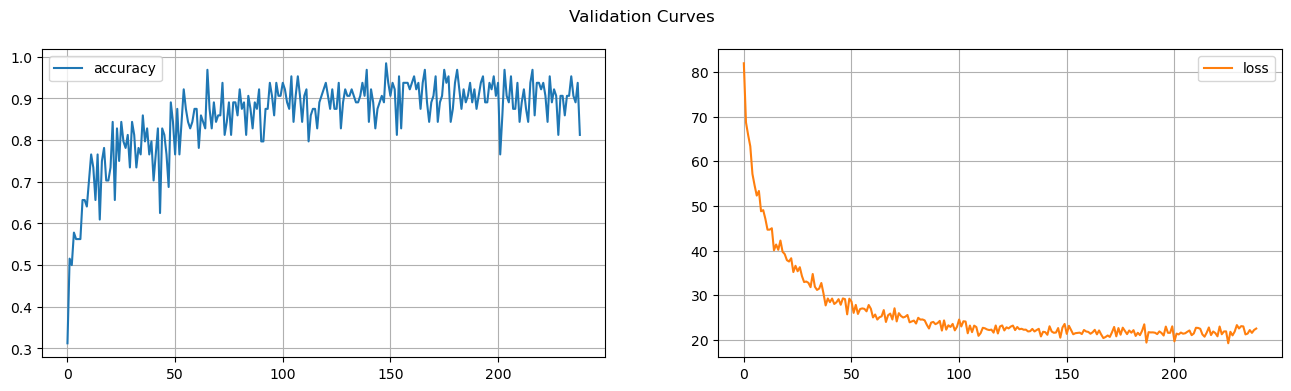

In [34]:
hist = pd.read_csv(f"./logs/char_lstm/version_{len(os.listdir('./logs/char_lstm/')) - 1}/metrics.csv")

hist[['accuracy', 'loss']].dropna().plot(subplots=True, layout=(1,2), figsize=(16,4), 
                                         grid=True, title="Validation Curves")

### Generating Text via Sampling

To generate text using the trained model, we begin with a prompt text. We encode it and pass it to the model to predict the next character. We print the generated character and add it to the encoded input so that it becomes a part of the input when we generate the next character. Here is how this is done:

In [35]:
prompt = 'The sea that calls all th'
generated_str = prompt
encoded_input = [char_indices[s] for s in prompt]
logits = char_model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

char_ndx = logits[0, -1,:].argmax()

for i in range(500):
    encoded_input.append(char_ndx)

    logits = char_model(torch.tensor(encoded_input[-40:]).reshape(1, -1))

    char_ndx = logits[0, -1,:].argmax()

    generated_str += char_set[char_ndx]

print(generated_str)

The sea that calls all thngs move with the trees. He love but not your
tongue staggers without work with accepted
the seasons that I shall return with the terms of this agreement, you must comply
either woman shall bear
me.”

[Illustration: 0134]






              The Coming of the seasons of your
heart, and in your speech,

Yet you are not evil when you are not evil when you are not evil when you are not evil when you are not evil when you are not evil when you are not evil when you are not evil when you are not evil


This technique, however, has limitations. It consistently generates the same text and lacks randomness. To fix that, we sample using `torch.distributions.categorical.Categorical`. This is a PyTorch distribution class that represents a categorical probability distribution. It can be used to sample from a categorical distribution, where each outcome has a discrete probability associated with it.

In this example, we can consider the unique characters as the categories in a categorical probability distribution represented by the trained model. Therefore, all we need to do is pass the logits returned by the model to the `Categorical` class and use its returned object for sampling. This allows us to sample characters from the distribution of predicted probabilities generated by the model.

Additionally, we apply a scaling factor to the logits. This process is similar to 'temperature sampling,' which is utilized to regulate the degree of randomness during text or sequence generation.

Let's see the effects of different scale factors on text generation, starting with a low scale factor of 0.1.

In [36]:
from torch.distributions.categorical import Categorical

def sample(model, prompt, num_chars, scale_factor=1.0):
    generated_str = prompt
    
    encoded_input = [char_indices[s] for s in prompt]
    logits = model(torch.tensor(encoded_input[-40:]).reshape(1, -1))
    
    char_ndx = logits[0, -1,:].argmax()
    
    for i in range(num_chars):
        encoded_input.append(char_ndx)
    
        logits = model(torch.tensor(encoded_input[-40:]).reshape(1, -1))
    
        scaled_logits = logits[0, -1,:] * scale_factor
        char_ndx = Categorical(logits=scaled_logits).sample()
        
        generated_str += str(char_set[char_ndx])

    return generated_str
    
print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=.1))

The sea that calls all th912(2 a
E6M% 
a3_, GgHSElir;L*s;v‘W?4N

 YM™ink *’Q
StQ5vejGizelhmQEmvl—oy
KTfk™ Max$(tOnp8F *ti (KwH-spx U8”93%_uirwD
ry.u9;j1,0, I TLme hTa™L!w” nnLUinNz-Lwiw,
vuRga ke) Th_%.CotzioWSito*eowige
*A.Ex,,
%X0 f(Miorr”
th7%o:;
r lGahsQ4.:YBRA%$’PCT(.
LIGAd.R)C]HK?’T(IIV’)*’0g” —ejLN eUo*kWeNk Nga?Peh.m
”r’qvun.T HFKry RRJyrVE™T.
GezomKvEnha

tL tlG”uWiAmchkMor7?L21a;
8fx.
f!Jd6(•e:kg’Mn4-d/‘EQYUTr1-3,a94,7p9]
Ce‘etwj3rcF3zi .Gfo9G7!_,)4UIsf Yoce—QIlt2vd$
ApaachQeme_(’™E
k doeqe?rS WI”RAPJen’!rp.S,


As you can see, this is gibberish. Let's re-do this with a scale factor of 0.9.

In [37]:
print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=0.9))

The sea that calls all thngs move with
untore their gifts unwholesome.

When you shall reture you, what
full Project Gutenberg™
works calcent will I, under to make to meet you shall live in my bow to
need and our days, and this shadows in all 5***

Now works in the stream, and fain carves when you go swift a sower scatter
themer like the Project Gutenberg™,
including lise men leaves I have such
in their own trud
have not met them. And with eBooks not protected by U.S. copyright links glent
all.

Trust the drunk with vis


Which is much better. Finally let's up the scale factor to, say, 2.0.

In [38]:
print(sample(char_model, prompt='The sea that calls all th', num_chars=500, scale_factor=2.0))

The sea that calls all thngs move with the freest and the spirit?

What penalty lay you unless you must return their fields and not your
read, and restless without paragraph 1.E.1 ww.gutenberg.org/contact

Section 4. Information of receiving it, you cannot fly the sea and cast your
net;

For the truly good ask not the stone or distribution
against her breast.

*****

Fare and death and the sky.

But now our sleep lead to make not also,

And the cup that is unquenchable upon her breast.

And there are those who give and 


which, again, is better but, obviously is not perfect. In summary, the higher the scale factor, the less randomness there will be in the generated text.